In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import emcee
import triangle
from scipy.misc import logsumexp

np.random.seed(42)

# Fitting a model to data with outliers using MCMC

We are often faced with data with spurious outliers. For example, a light curve generated from some automated photometric pipeline with failures in the background subtraction on some nights. It is tempting to remove these outliers by eye, or by some automatic procedure (e.g., sigma clipping), however these points may actually contain valuable information. Your model should be able to account for these data! Luckily, it is relatively easy to account for this within a statistical model: the data are modeled as being either drawn from your physical model, or an outlier model with an extra parameter to specify the global weights of these two distributions.

Below we consider a trivial but illustrative example. This problem is described in a little more detail in Section 5.6.7 of [Statistics, Data Mining, and Machine Learning in Astronomy](http://www.astroml.org/). Another good reference is David Hogg's [Fitting a model to data](http://arxiv.org/abs/1008.4686) paper.

---

## Example data

We take images of a variable star at random times over the course of a year. We have some automated pipeline that reduces the data, and spits out magnitudes for each observation. Some nights, the pipeline fails, but the way in which we estimate uncertainties on the measured magnitudes doesn't account for these failures, leading to outliers in the final data product (a light curve). For now, we'll assume the shape of the light curve is a perfect sinusoid, but in principle any template could be used. Our goal will be to measure the amplitude, period, and phase of the sinusoid given noisy observations of the star.

We start by definining some helper functions to generate the fake data:

In [2]:
def sinusoid(t, amp, period, phase):
    """ A generic sinusoidal curve. 'period' and 't' should have 
        the same units (e.g., days), and phase should be in
        radians. 
        
        Parameters
        ----------
        t : array_like
            Array of times.
        amp : numeric
            Amplitude of the sinusoid.
        period : numeric
            Period of the sinusoid.
        phase : numeric
            Phase of the sinusoid.
    """
    return amp*np.sin(2*np.pi*t/period + phase)

def light_curve_model(p, t):
    """ Our model for the variable star light curve will be a 
        pure sinusoid plus some constant offset (the mean 
        magnitude of the star). The function takes a single array
        of parameters, p, and an array of times, t. By structuring
        the function input parameters this way, we can use this 
        function to both generate and later fit the data.
        
        Parameters
        ----------
        p : iterable
            A list, tuple, or array of model parameter values. For
            example, a tuple of (amplitude, period, phase, mean mag.).
        t : array_like
            Array of times.
    """
    amp, period, phase, const = p
    return sinusoid(t, amp, period, phase) + const

Now we'll actually generate the fake data. The cell below contains tunable parameters -- if you want to change the number of data points, the fraction of points that are outliers, or the true model parameters, modify the variables in this cell (you'll have to download the full version of this notebook):

In [3]:
ndata_points = 32 # number of data points
outlier_fraction = 0.1 # 10% of the points will be outliers

true_amplitude = 1.5 # mag
true_period = 112. # days
true_phase = 1.5 # radians
true_mean_mag = 14. # mag

---

In [4]:
# pack the true parameters into a single tuple
true_params = (true_amplitude, true_period, true_phase, true_mean_mag)

# generate an array of observation times
time = np.random.uniform(0., 365., size=ndata_points)
time.sort()

# generate magnitude values from the model at the observation times
mag = light_curve_model(true_params, time)

# each data point will have a different uncertainty, sampled from 
#    a uniform distribution between 0.2 and 0.4 magnitudes
mag_err = np.random.uniform(0.2, 0.4, size=ndata_points)

# pick outlier points based on the set outlier_fraction. we generate a
#    boolean array (array of True's and False's) -- when a given index
#    is True, that point will become an outlier
outlier_idx = np.random.uniform(size=ndata_points) < outlier_fraction

# for the outlier points, add large scatter
mag[outlier_idx] += np.random.normal(0., 5., size=sum(outlier_idx))

# for the non-outlier points, add scatter based on the uncertainty array (mag_err).
#    the twiddle (~) means 'logical not' - (True becomes False, False becomes True) 
mag[~outlier_idx] += np.random.normal(0., mag_err[~outlier_idx])

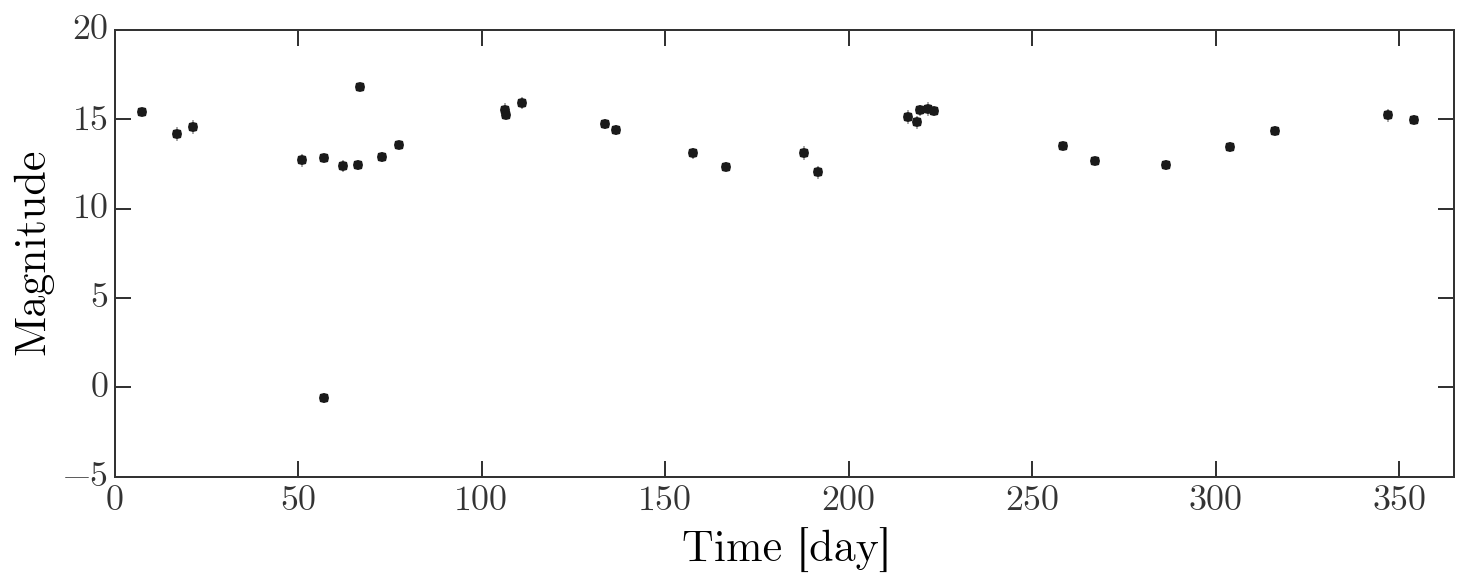

In [5]:
plt.figure(figsize=(12,4))
plt.errorbar(time, mag, mag_err, marker='o',
             linestyle='none', ecolor='#aaaaaa')
plt.xlim(0,365)
plt.xlabel("Time [day]")
plt.ylabel("Magnitude")

---

Now we're armed with some fake data in the form of 3 arrays: the observation times, magnitudes, and uncertainties for the magnitudes (we'll assume we can measure the time of observation to arbitrary precision). We'll start by trying to fit our light curve model _without_ taking into account the outliers. We're going to use the same model that we used to generate the data, but ignore the fact that there are outlier points.

If we assume that each data point is independent and has Gaussian uncertainties (as we have done by construction), we can write down a likelihood for each $i$ data point as a Gaussian:

$$
p(m_i \,\vert\, A,T,\phi,m_0,\sigma_{m,i},t_i) = \frac{1}{\sqrt{2\pi\sigma_{m,i}^2}} \exp \left(-\frac{(m_i - f(t_i, A, T, \phi, m_0))^2}{2\sigma_{m,i}^2}\right)
$$

where our light curve model is expressed as the function $f$:

$$
f(t_i, A, T, \phi, m_0) = A\sin(\frac{2\pi t_i}{T}+\phi) - m_0
$$

This looks just like a $\chi^2$ function because we are assuming our data are drawn from a Gaussian around some true model with the parameters amplitude, $A$, period, $T$, phase, $\phi$, and mean magnitude, $m_0$. The full likelihood (over all data points) is then the product of these of the individual probabilities:

$$
\mathcal{L} = \prod_i^N p(m_i \,\vert\, A,T,\phi,m_0,\sigma_{m,i},t_i) = p(\{m_i\}_N \,\vert\, A,T,\phi,m_0,\{\sigma_{m,i}\}_N,\{t_i\}_N)
$$
where the notation $\{m_i\}_N$ means the set of all $N$ data points.

For this example, we will assume uniform priors over all parameters, $p(A)\,p(T)\,p(\phi)\,p(m_0)$. It is a __bad idea__ to define uniform priors over angular parameters (like the phase, $\phi$, in this example), but I've done it anyway for simplicity. In this case, we could just maximize this likelihood to find the "best fit" parameters, but instead we will use MCMC to sample from the posterior probability over the model parameters. The full posterior probability for our model is then given by:

$$
p(A,T,\phi,m_0 \,\vert\, \{m_i\}_N, \{\sigma_{m,i}\}_N, \{t_i\}_N) = \frac{1}{\mathcal{Z}} p(\{m_i\}_N \,\vert\, A,T,\phi,m_0,\{\sigma_{m,i}\}_N,\{t_i\}_N)\,p(A)\,p(T)\,p(\phi)\,p(m_0)
$$

where the constant, $\mathcal{Z}$, only depends on the properties of the data -- which we are not varying -- and thus we can ignore it for optimization. 

In practice, evaluating the logarithm of the posterior is often more stable to numerical issues (e.g., overflow or underflow), so below we define functions to evaluate the log of all of the above probabilities. This, combined with using uniform priors means that the priors evaluate to 0 when a value is outside of the specified range and are constant within the defined range. 

In [6]:
def lnprior(p):
    amp,period,phase,const = p
    
    if amp < 1 or amp > 2:
        return -np.inf
    
    if period < 10 or period > 200:
        return -np.inf
    
    if phase < 0. or phase > 2*np.pi:
        return -np.inf
    
    if const < 12 or const > 16:
        return -np.inf
    
    return 0.

def lnlikelihood(p, t, data, err):
    amp,period,phase,const = p
    return -np.log(err) - 0.5*( (data - sinusoid(t, amp, period, phase) - const) / err )**2

def lnprob(p, t, data, err):
    return lnprior(p) + np.sum(lnlikelihood(p, t, data, err))

In [7]:
ndim, nwalkers = 4, 32
p0 = np.zeros((nwalkers,ndim))
p0[:,0] = np.random.uniform(1, 2., size=nwalkers) # amp
p0[:,1] = np.random.uniform(10, 200., size=nwalkers) # period (days)
p0[:,2] = np.random.uniform(0., 2*np.pi, size=nwalkers) # phase (radians)
p0[:,3] = np.random.uniform(12., 16., size=nwalkers) # const. offset (mag)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(time,mag,mag_err))

In [8]:
pos, prob, state = sampler.run_mcmc(p0, 1000)

best_pos = sampler.flatchain[sampler.flatlnprobability.argmax()]
pos = emcee.utils.sample_ball(best_pos, best_pos/100., size=nwalkers)
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 100)

sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

/Users/adrian/anaconda/lib/python2.7/site-packages/emcee-2.1.0-py2.7.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/adrian/anaconda/lib/python2.7/site-packages/emcee-2.1.0-py2.7.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


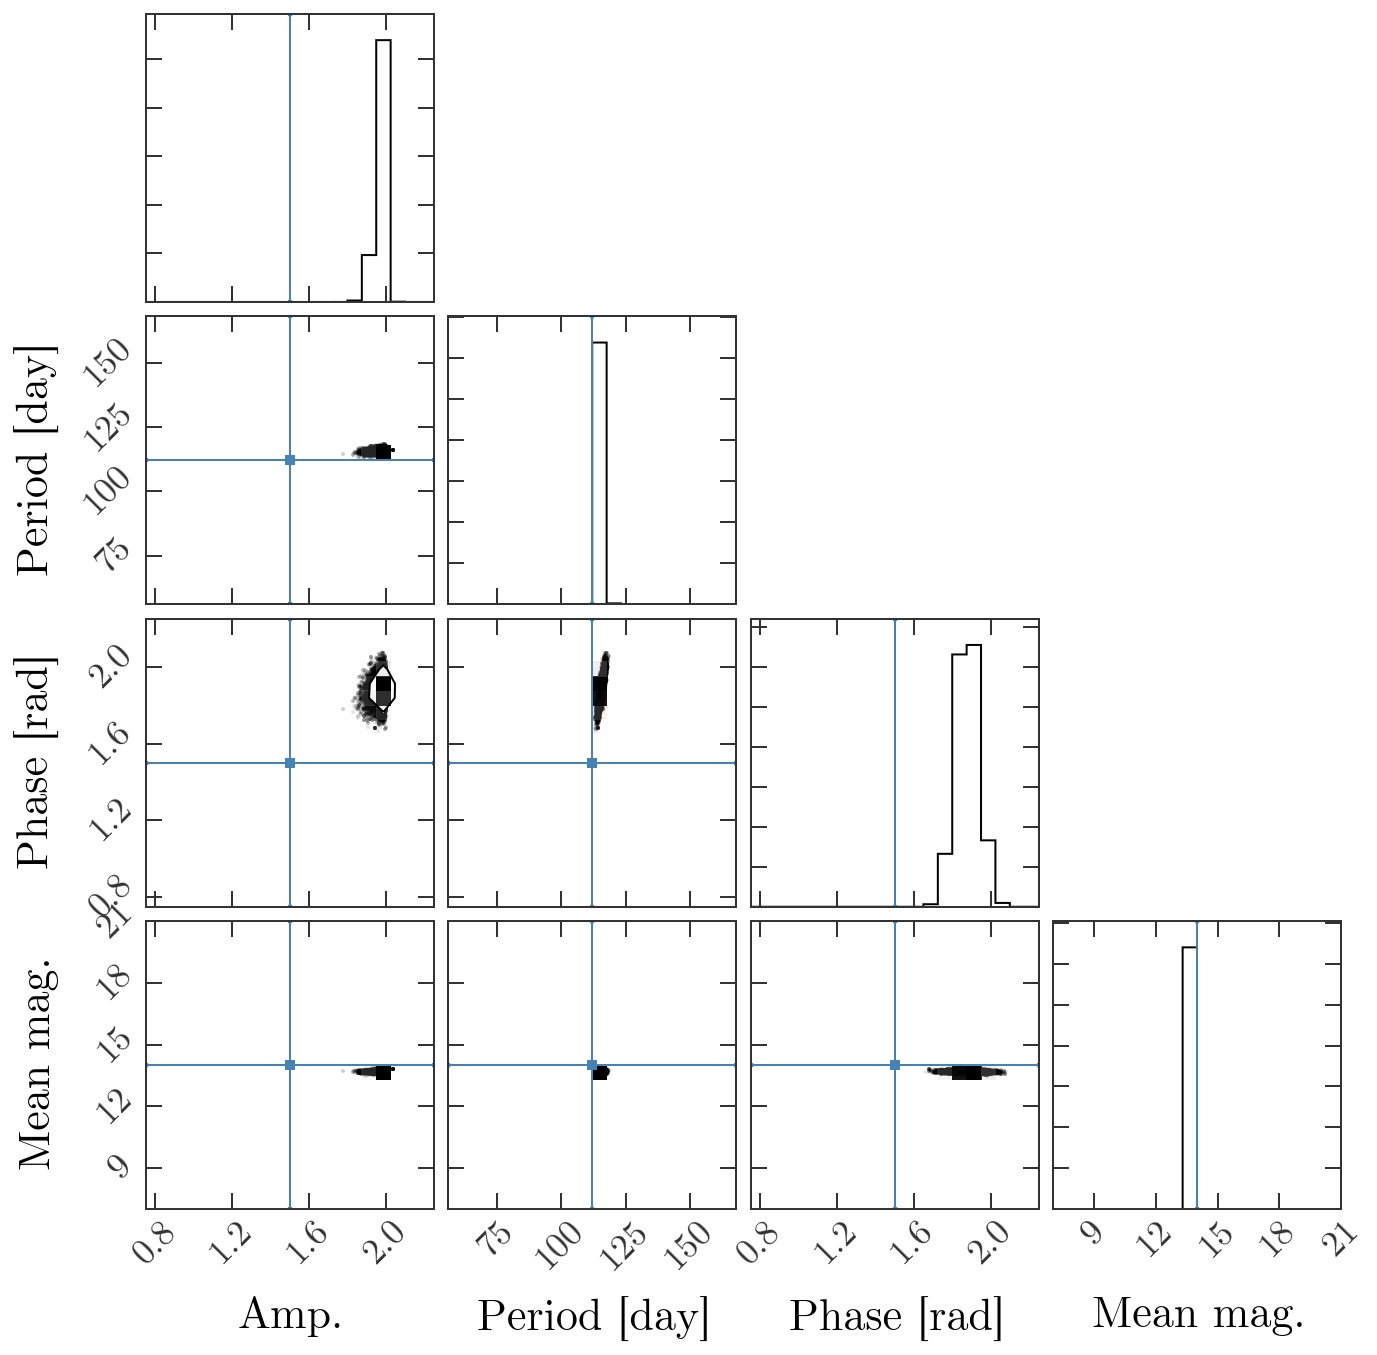

In [10]:
param_labels = ["Amp.", "Period [day]", "Phase [rad]", "Mean mag."]
extents = [(0.5*truth,1.5*truth) for truth in true_params]
fig = triangle.corner(sampler.flatchain, 
                      labels=param_labels,
                      truths=true_params,
                      range=extents)

Interesting -- we almost nailed the mean magnitude, but period, phase, and amplitude are biased (by many percent).

Let's draw some samples from this posterior and plot the models over the data:

(7.5133404179678926, 354.01709603912792)

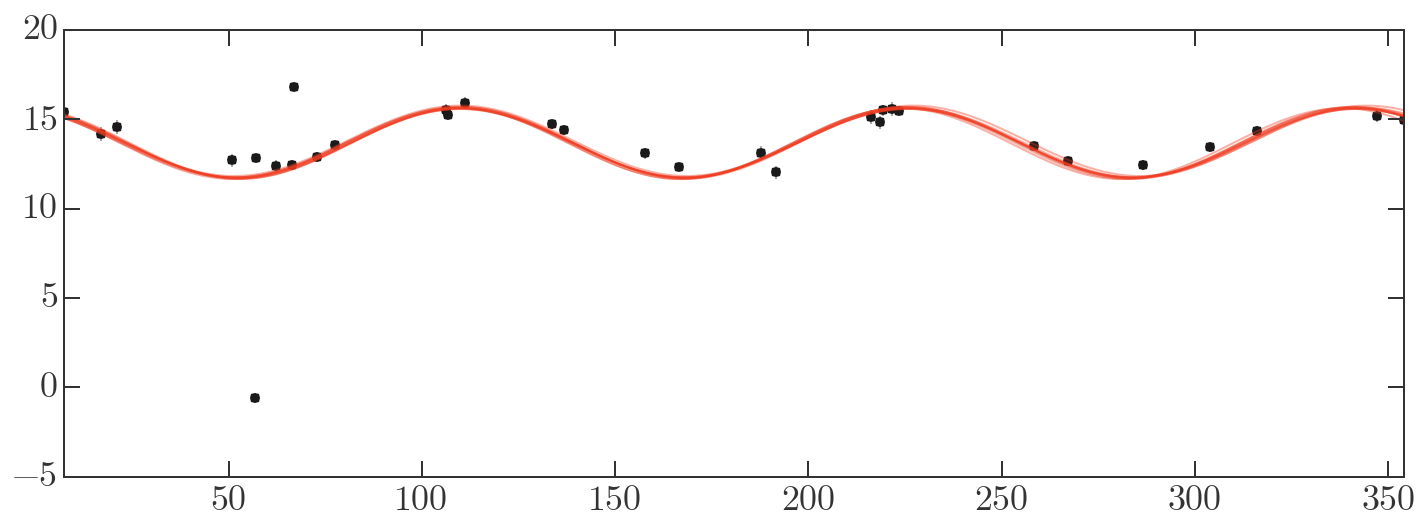

In [11]:
nsamples = sampler.flatchain.shape[0]

plt.figure(figsize=(12,4))
plt.errorbar(time, mag, mag_err, marker='o',
             linestyle='none', ecolor='#aaaaaa')

t = np.linspace(min(time), max(time), 1000)
for ii in range(10):
    idx = np.random.randint(0, nsamples)
    params = sampler.flatchain[idx]
    model_mag = light_curve_model(params, t)
    plt.plot(t, model_mag, 
             marker=None, color='#f03b20', alpha=0.4)

plt.xlim(min(time), max(time))

What can we do about this? 

We can define a mixture model! We add a new parameter to the model: the fraction of stars that are instead drawn from some very broad outlier distribution. There are many possible options for that to put in for this outlier distribution, but below we will assume that the outlier distribution is still centered on the model, but with a huge variance. Our "inlier" distribution will be the same as above:

$$
p_{\rm in} = p(m_i \,\vert\, A,T,\phi,m_0,\sigma_{m,i},t_i) = \frac{1}{\sqrt{2\pi\sigma_{m,i}^2}} \exp \left(-\frac{(m_i - f(t_i, A, T, \phi, m_0))^2}{2\sigma_{m,i}^2}\right)
$$

and our outlier distribution:

$$
p_{\rm out} = p(m_i \,\vert\, A,T,\phi,m_0,V,t_i) = \frac{1}{\sqrt{2\pi V}} \exp \left(-\frac{(m_i - f(t_i, A, T, \phi, m_0))^2}{2 V}\right)
$$

where $V$ is arbitrarily fixed to be 10 times the median uncertainty of the data. The new likelihood for a single point is then:

$$
\mathcal{L}_i = (1-f_{\rm bad})p_{\rm in} + f_{\rm bad}p_{\rm out}
$$

$f_{\rm out}$ represents the fraction of the data points that are outliers, and this will be a new parameter in the model.

In [12]:
def lnprior(p):
    amp = p[0]
    period = p[1]
    phase = p[2]
    const = p[3]
    fout = p[4]
    
    if amp < 1 or amp > 2:
        return -np.inf
    
    if period < 100 or period > 200:
        return -np.inf
    
    if phase < 0. or phase > 2*np.pi:
        return -np.inf
    
    if const < 12 or const > 16:
        return -np.inf
    
    if fout > 1. or fout < 0.:
        return -np.inf
    
    return 0.

def ln_model_likelihood(p, t, data, err):
    amp, period, phase, const, outlier_prob = p
    term = -np.log(err) - 0.5*( (data - sinusoid(t, amp, period, phase) - const) / err )**2
    return term

def ln_outlier_likelihood(p, t, data, err):
    amp, period, phase, const, outlier_prob = p
    outlier_err = 10.*np.median(err)
    term = -np.log(outlier_err) - 0.5*( (data - sinusoid(t, amp, period, phase) - const) / outlier_err )**2
    return term
        
def lnlikelihood(p, t, data, err):
    amp, period, phase, const, fout = p
    
    term1 = ln_model_likelihood(p, t, data, err)
    term2 = ln_outlier_likelihood(p, t, data, err)
    
    b = np.ones((2,len(t)))
    b[0] = 1. - fout 
    b[1] = fout
    
    return logsumexp(np.vstack((term1, term2)), b=b, axis=0)
    
def lnprob(p, t, data, err):
    prior = lnprior(p)
    if np.isinf(prior):
        return -np.inf
    
    return prior + np.sum(lnlikelihood(p, t, data, err))

In [13]:
ndim, nwalkers = 5, 64
p0 = np.zeros((nwalkers,ndim))
p0[:,0] = np.random.uniform(1, 2., size=nwalkers) # amp
p0[:,1] = np.random.uniform(100, 200., size=nwalkers) # period (days)
p0[:,2] = np.random.uniform(0., 2*np.pi, size=nwalkers) # phase (radians)
p0[:,3] = np.random.uniform(12., 16., size=nwalkers) # const. offset (mag)
p0[:,4] = np.random.normal(0.5, 0.05, size=(nwalkers)) # outlier probabilty

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(time,mag,mag_err))

In [14]:
pos, prob, state = sampler.run_mcmc(p0, 1000)

best_pos = sampler.flatlnprobability.argmax()
new_pos = emcee.utils.sample_ball(sampler.flatchain[best_pos], 
                                  sampler.flatchain[best_pos]/100, 
                                  size=nwalkers)

sampler.reset()
pos, prob, state = sampler.run_mcmc(new_pos, 1000)

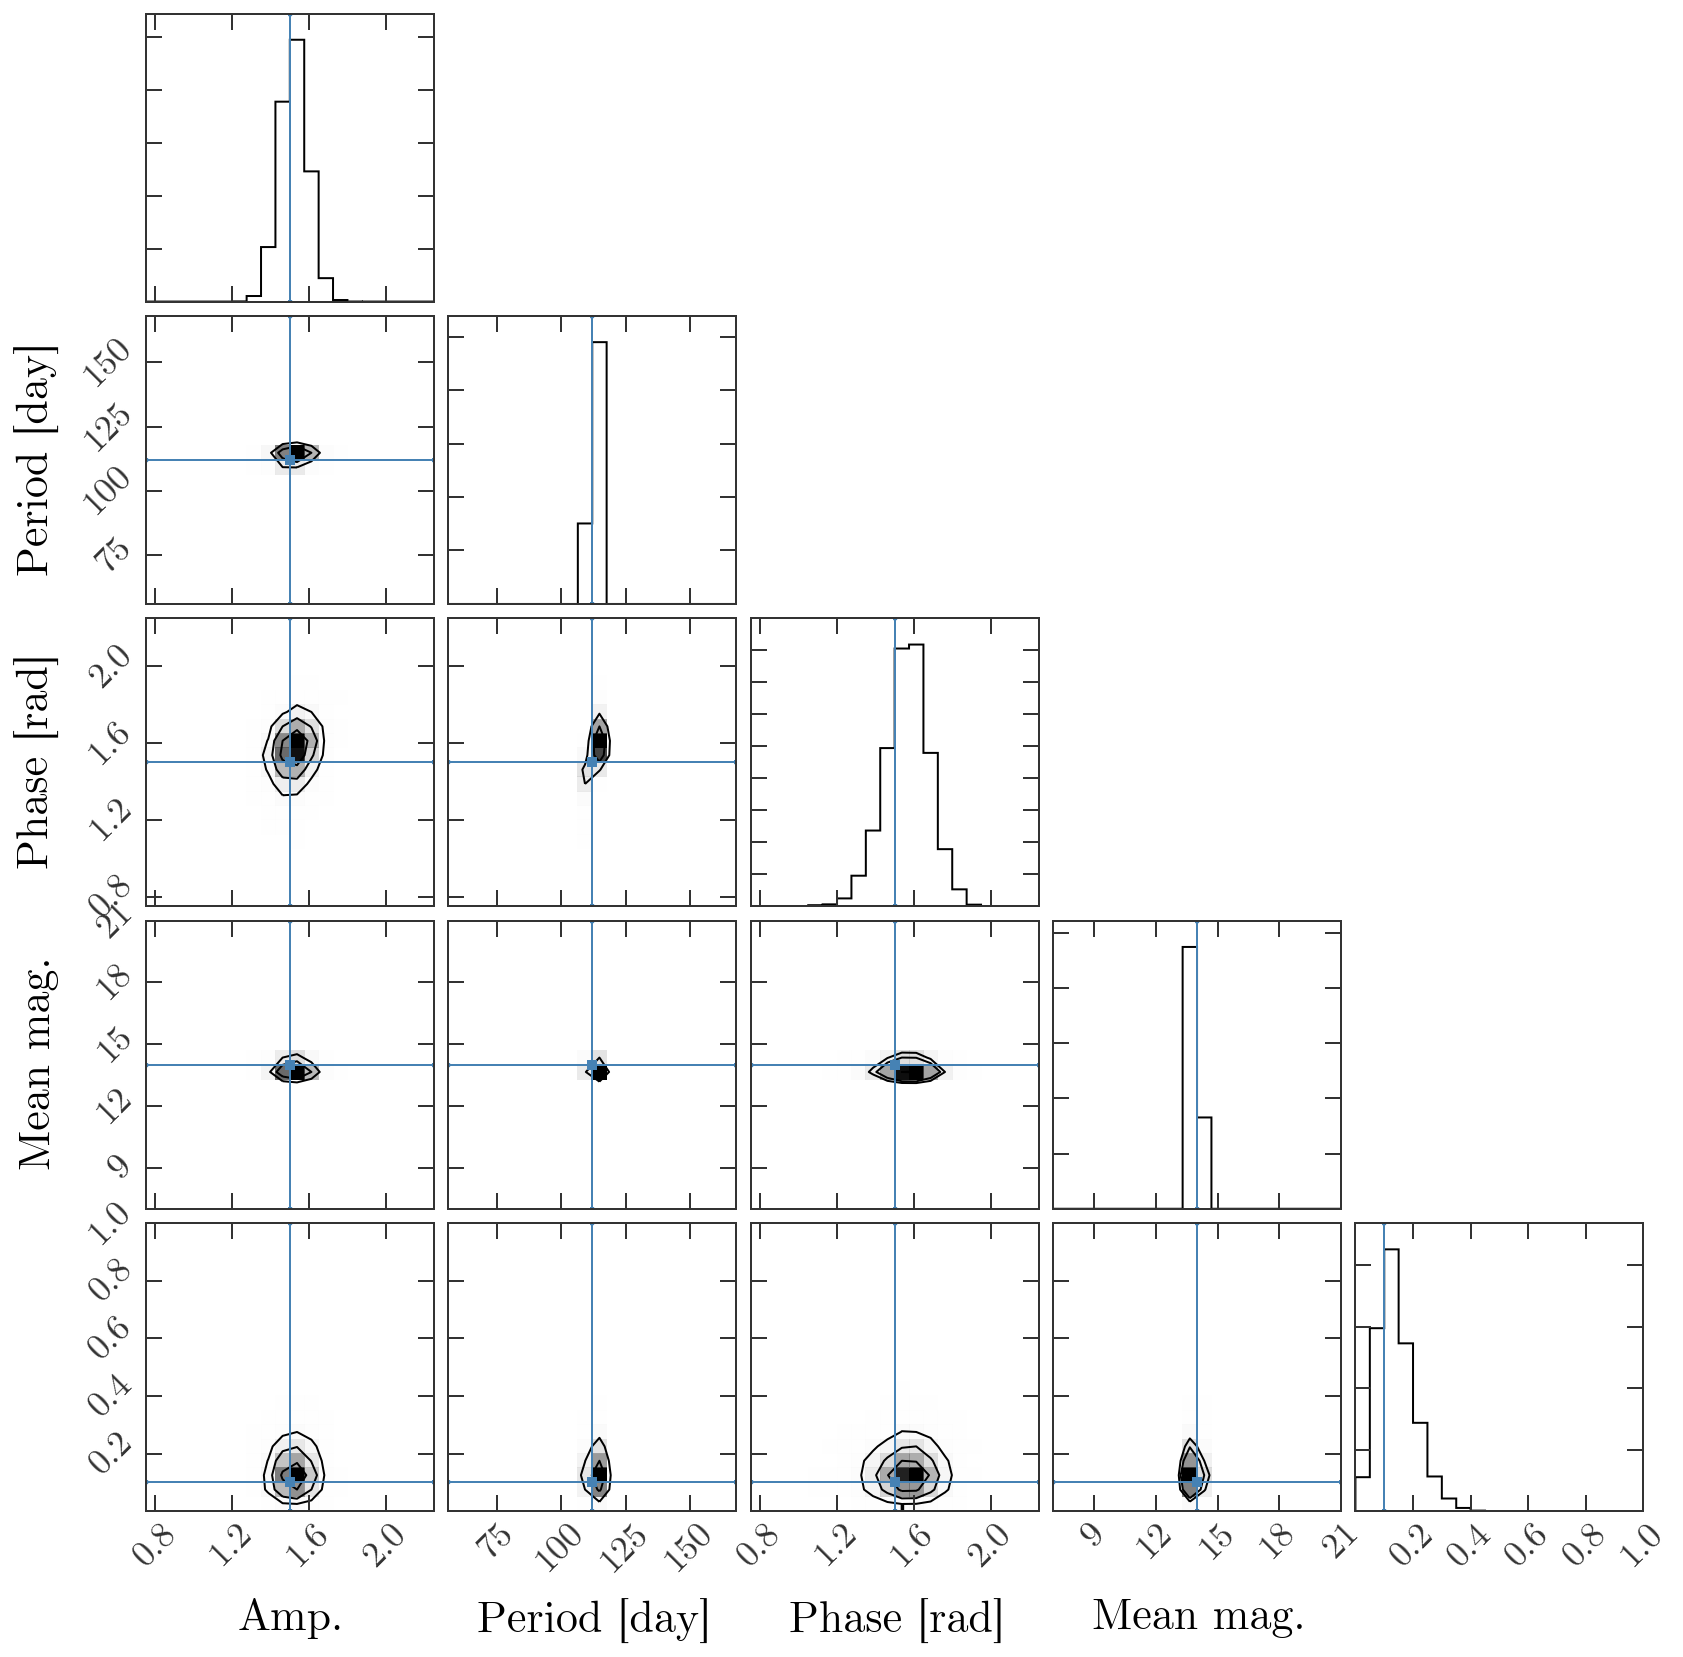

In [15]:
extents = [(0.5*truth,1.5*truth) for truth in true_params] + [(0,1)]
fig = triangle.corner(sampler.flatchain[:,:], 
                      labels=param_labels + [""],
                      truths=list(true_params) + [0.1],
                      range=extents,
                      plot_datapoints=False)

(7.5133404179678926, 354.01709603912792)

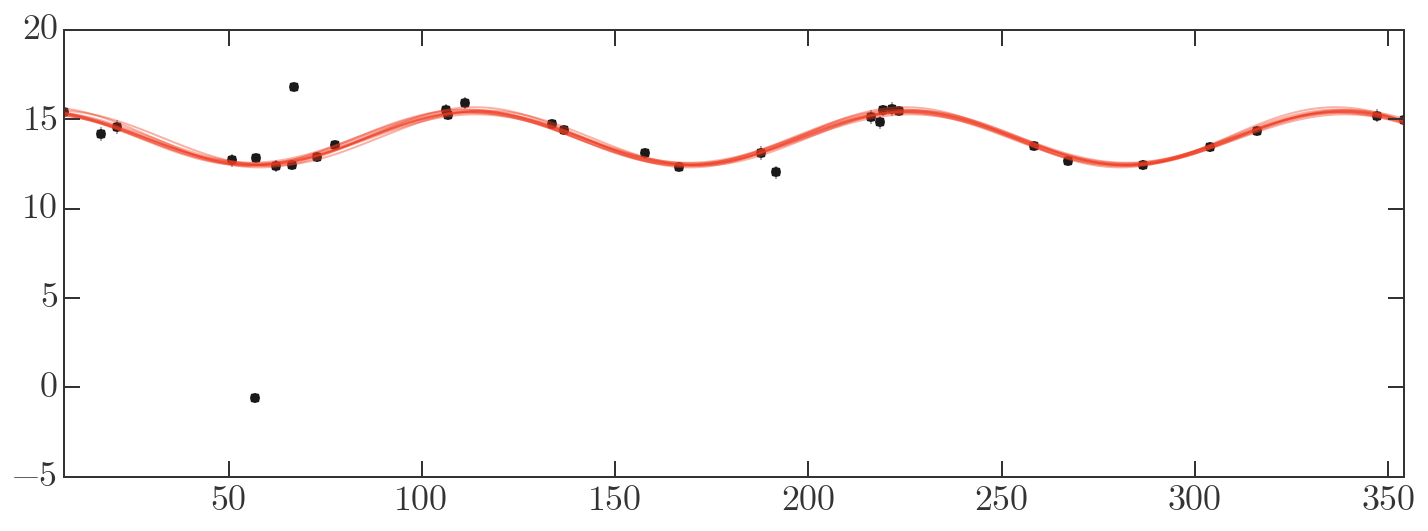

In [16]:
nsamples = sampler.flatchain.shape[0]

plt.figure(figsize=(12,4))
plt.errorbar(time, mag, mag_err, marker='o',
             linestyle='none', ecolor='#aaaaaa')

t = np.linspace(min(time), max(time), 1000)
for ii in range(10):
    idx = np.random.randint(0, nsamples)
    params = sampler.flatchain[idx,:4]
    model_mag = light_curve_model(params, t)
    plt.plot(t, model_mag, 
             marker=None, color='#f03b20', alpha=0.4)

plt.xlim(min(time), max(time))